# Introduction to the use of classifiers for neuroimaging

In this notebook, we will break down the steps necessary to perform decoding analyses on brain data. We follow very closely the example at http://nilearn.github.io/auto_examples/decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-decoding-plot-haxby-different-estimators-py

It is structured in the form of a tutorial with instructions for each step. The solution to each step can be loaded into the next cell and compared to the work done by oneself.

## Preliminaries
It is good to assemble most imports of packages and settings at the top of the document. We will not be strict about this here, since we will discover some packages along the way, but let us take care of the essentials:

Please do the following:
1. Make sure plots will be inline by using the magic commande `matplotlib inline` to this effect
2. Import `matplotlib.pyplot` and call it `plt` (for plotting)
3. Import `numpy` and call it `np` (for all core calculations)
4. Import `nibabel` (for loading and saving nifti-images)

In [55]:
# %load preliminaries.py

## Obtaining and understanding the data

We would like to use some neuroimaging data to test classifiers. For that we need to know where the data are, i.e. under which filenames they are stored and how to load and work with them.

### The concept of the niimage
In `nilearn`, we try to make data handling as easy as possible. While you can manually load nifti files and look inside them using `nibabel` (we will do this), `nilearn` accepts simple file paths to the data in almost all cases. When it receives a file path or a list of file paths, it knows it will need to load the file or files indicated.

### The nilearn datasets
Nilearn provides easy access to a variety of free, publicly available datasets. Helper functions are available to download them from the Internet. They are downloaded to a specific folder, and the filenames are listed in the output of the helper functions.

Take a moment to discover the datasets via tab-completion:
`from nilearn.datasets import <TAB>`

Then import the function `fetch_haxby`. Use it to find the file specifies for 1 subject. Also opt to import the stimuli file paths.

In [57]:
# %load fetch_data.py

### Understanding nilearn data bunches

Take a moment to explore the object `haxby_data`.

1. First, print the description.
2. Identify the file containing the BOLD functional MRI responses for subject 2 and put it in the variable `func_file`. Print the filename to the screen.
3. Identify the experimental condition file indicating what the subject was seeing during all the sessions and put is in the variable `target_file`. Print the filename to the screen.


In [60]:
# %load print_file_names.py

### Taking a quick look at the files (optional)

It is always good to have a feeling for what is actually inside the files that we are going to work with. How does the `target_file` actually contain the target? What does the functional file look like?

Optionally, do the following:
- for Mac and Linux users, take a look at the first 5 lines of the target file using `!head <FILE>` where `<FILE>`is to be replaced with the filename
- for all users, write a simple python loop up to 5, printing each time a line of the file you have opened with `f = open(target_file)`.
- Load the functional imaging file using `nibabel` and print its shape.

- (Use the `mean_image` and `plot_stat_map` functionalities to get an idea of the functional images)

In [62]:
# %load head_labels.py

### Loading the target file into an array

If you have visualized the first few lines of the target file, you will have seen that it is a two-column table, a so-called csv (comma-separated value) file. Except that here the separator is a space. Observe that the left-hand column contains numbers and the right-hand column contains words. The left-hand column indicates the **scanner run** in which a data point was acquired, whereas the right-hand column informs us about which **target image type** was shown or whether the subject was at rest.

There are many ways to load this textfile into memory for further use. The goal is to have

1. A list or an array named `labels` containing the words
2. A list or an array named `runs` containing the indices of the scanner run

Apart from opening the file by hand, here are some easy commands you can use. For some, you will need to specify that the columns are separated/delimited by spaces (keywords `delimiter` or `sep`):

- `np.recfromcsv`
- `pandas.read_csv`
- `pandas.recfromtxt`

In [64]:
# %load load_csv.py

## Masking the neuroimaging data - the connection to scikit-learn

Neuroimaging data of the brain is most often in volume form: One image is a 3D voxel-image. Since the relevant region is always inscribed in a cube of voxels, it is probable that many of the voxels do not interest us - either because they are outside the brain or outside a region of interest in the brain that we have specified. In order to restrict ourselves to the voxels that interest us, we have to mask.

A mask is a binary image that contains a 1 for each position that we would like to keep and a 0 for each position we would like to discard.

Since the shape we are masking doesn't necessarily have to be a cube, we do not order the result spatially anymore: We just enumerate the positions of interest, and these will appear as columns in the masked data.

If we are masking several images at once (i.e. a 4D image e.g. (x, y, z, t)), then the result will be a table (2D array), each line of which is once masked 3D image. This format is perfect for use with scikit-learn, as we will see.

### What if we don't have a mask, but would like to restrict ourselves to the brain?
Glad you asked. This situation happens regularly and nilearn provides an elegant solution. If no mask is specified, the `NiftiMasker` can estimate it by itself and more often than not finds a good segmentation of brain/not-brain to continue with, in addition to bringing the data into the right format for scikit-learn.

We will start by taking a look at how this works and by verifying the mask image afterwards.

1. Import the `NiftiMasker` from `nilearn.input_data`
2. Instantiate one of them and call it `masker`
3. Fit the masker to the functional data by using its method `fit` and providing the functional data file.


NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=None, mask_strategy='background',
      memory=Memory(cachedir=None), memory_level=1, sample_mask=None,
      sessions=None, smoothing_fwhm=None, standardize=False, t_r=None,
      target_affine=None, target_shape=None, verbose=0)

In [66]:
# %load naive_masker.py

Now let us check what type of mask the `NiftiMasker` has found for us:

1. Retrieve the data from the mask image, which can be found in `masker.mask_img_` by calling `get_data` on it and saving the result in the variable `mask`.
2. Take a look at the shape of the mask by printing it
3. Use `plt.matshow` to show e.g. slice number 20 of the mask (`mask[20]`)
4. Import the function `plot_roi` from `nilearn.plotting`. Use it to plot the `masker.mask_img_` directly. Use the option `bg_img=None`.

In [108]:
# %load show_naive_mask.py


Weird, huh? Where is the brain? Doesn't seem that this masking went too well. As a matter of fact, here we have a case of failed masking. The best strategy to separate brain voxels from non-brain-voxels actually highly depends on the type of brain data that is input. The default setting for the masker is set such that certain brain maps out of SPM are segmented correctly. That is not the case here, so we need to switch the masking strategy:

1. Reinstantiate the masker specifying the keyword `mask_strategy='epi'`
2. Redo the same things as above.

In [109]:
# %load better_mask.py


That should look more like a sagittal cut of a brain.

Now that we have found a useful mask, we can use it to mask the brain image:

1. Use the method `transform` of the masker to transform the functional file and call the result `X_full`

In [72]:
# %load full_transform.py

### Masking with a given mask
However, in many cases we may know exactly what mask we want to use. In this case, it should be specified at the instantiation of the mask.

1. Find the mask of the ventral-temporal region (`mask_vt`) in the `haxby_data` bunch and instantiate a masker with it.
2. Mask the functional data using this mask and store the result in the variable `X`. You can use the method `fit_transform` to this effect.
3. Show the mask using `plot_roi`

In [74]:
# %load mask_ventral.py

## Multi-class classification

Now let us turn to the task of predicting the type of stimulus presented to the subject. Take a look at the array `labels` which you created earlier.

Specifically, determine the unique elements it contains in order to have an idea what the categories are that are presented. You can use the function `np.unique` on `labels` to do this.

In [76]:
# %load unique_labels.py

You will realize that there is a category `rest`, during which the subject did not look at anything. We would like to discard this condition. Before we do this, print the shapes of `X` and `labels` and observe that they correspond on the first axis:

In [78]:
# %load print_shapes.py

This means that for each line of `X` (i.e. each masked brain image), there is exactly one corresponding label.

We would like to now remove the brain images corresponding to resting state and also the labels corresponding to resting state in order to keep the sizes of the array the same. In order to do this, first create an array identifying all labels that correspond to resting state. 

1. Create this array and call it `resting_state`. Take a look at it.
2. Then use this array to index `X` and `labels` such that they contain everything but resting state. For this, you may find it useful to negate `resting_state`, by using e.g. `np.logical_not(resting_state)` or simply `~resting_state`. Make sure you call the results `Xtask` and `ytask` respectively.

In [80]:
# %load mask_resting_state.py

### Trying out SVM

We now proceed to our first classification. To this end, we will use a standard, linear support vector machine. In order to use it, you first need to import the relevant scikit-learn estimator by importing `SVC` from `sklearn.svm`

In [82]:
# %load import_svm.py

### Evaluation of machine learning algorithms

We could train our SVM on all of the data. But the question arises as to how we would evaluate whether it works well or not. In the context of statistical learning, evaluation is always done on data that the model has never seen. In order to be able to do this, we need to hold back some data. We could do this by hand, for example by deciding to train on half the data.

Optional: Divide the data in half by using `Xdata[0:Xdata.shape[0] / 2]` and calling it `Xtrain` and the other half `Xdata[Xdata.shape[0] / 2:]`, which you will call `Xtest`. Do the same for the labels.

In [84]:
# %load split_half_data.py

Maybe we do not want to divide our data in half. Maybe we would like to keep a different size test set. Since data splitting is a very common necessity, scikit-learn has many utilities to do this, of which we will see a few.

1. import the function `train_test_split` from `sklearn.cross_validation`
2. use it to divide both `Xtask` and `ytask` into train and test sets. By using the keyword `stratify=True`, you can make sure that the proportions of labels stay the same in train and test sets

In [86]:
# %load train_test_split.py

We can now proceed to training an SVM.

1. Create an SVM object by calling `SVC(kernel='linear')` and calling it `svm`
2. Train the svm object by calling the method `fit` with the arguments `Xtrain, ytrain`

In [88]:
# %load train_svm_simple.py

Now let's test it on our test data. How do we go about this? Since we are in a predictive context, let's use the SVM to predict the labels of the test set.

Call the method `predict` of the `svm` object and give it `Xtest` as an argument. Store the predictions in an array `ypredict`.

In [90]:
# %load predict_svm_simple.py

Now that we have the predictions, we need to somehow compare them to the actual labels and draw some conclusions. The simplest possible scoring method is accuracy score, in which we just evaluate the fraction of correct predictions. We can create an array indicating whether each prediction is correct by using the comparison operator `==`: Check out the array `ytest == ypredict` and take its mean by calling the method `mean` on it. Call the result `score` and take a look at it.

In [92]:
# %load calculate_accuracy_simple.py

### Cross-validation

Now we have obtained one score for our classifier by holding out some data, training the classifier and predicting the target labels of the held-out data. We then looked at the fraction of correctly predicted labels. If this fraction is high, it can mean that our predictor is good. But note that it is not sufficient to state this score alone for several reasons:

1. Imagine you have 90 labels of one type and 10 of another. Then you can obtain 90% accuracy just by always predicting the first label. 90% is then called *chance level* and you have to do better in order to be able to conclude that your classifier actually does something. If the labels are evenly distributed into N classes, then the chance level lies at 1/N. For example, for two balanced classes it is 50%

2. What if we had split the data differently? Would we obtain similar scores? The answer is *hopefully*, because if not, then interpretation becomes difficult. In any case, one should evaluate at least 5 or more of these train/test splits and look at the average scores as well as how much they spread around this average.


Assuming a balanced distribution of labels, we will concentrate now on solving the second issue. Again, since this is a very common setting in machine learning, scikit-learn provides many tools to do several train/test splits. Splitting several times and evaluating is called **cross-validation**.

1. Import the function `cross_val_score` from the scikit-learn module `sklearn.cross_validation`
2. Use this function to split the data 10 times by calling it with the svm, the `Xtask` and `ytask` data. Store the result in `scores`.
3. print the scores




In [94]:
# %load one_cross_validation.py

We can now analyse these scores by taking the mean using `np.mean`. In order to evaluate the spread around the mean, also take a look at the standard deviation using `np.std`

In [ ]:
# %load mean_std_scores.py

## Exercise: Evaluating several classifiers on the same data.

Open the example http://nilearn.github.io/auto_examples/decoding/plot_haxby_different_estimators.html in your browser. Read the code and identify what you have already achieved by doing this notebook (start at the second section). Then follow up by implementing a loop over several classifiers in order to compare them on these data. If there is time, proceed to the visualization section.

Bonus: Check out the estimators `sklearn.linear_model.Lasso` and `sklearn.ensemble.RandomForest`

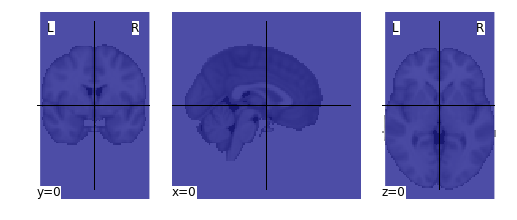

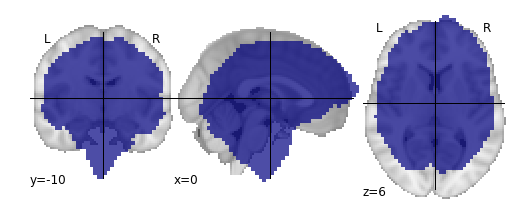

In [102]:
from nilearn.plotting import plot_roi

masker = NiftiMasker()
masker.fit(func_file)
plot_roi(masker.mask_img_)
masker = NiftiMasker(mask_strategy='epi')
masker.fit(func_file)
plot_roi(masker.mask_img_)